# 

In this notebook we explore the opportunities for the qubit MILP

Let's first generate a random qiskit circuit.

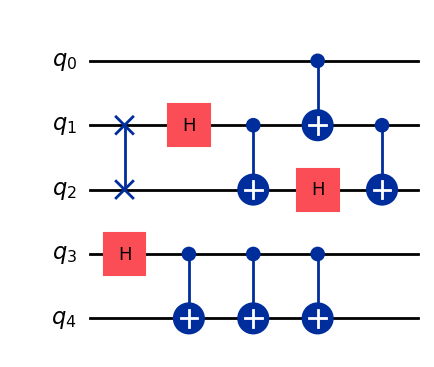

In [49]:
import qiskit.circuit.random
import qiskit
import qiskit.circuit.library.standard_gates
import random

import quariadne.circuit

QUBIT_COUNT = 5
NUM_GATES = 10
SEED = 156

random.seed(SEED)

MAX_OPERANDS = 2

STANDARD_GATE_SET = ["cx", "h", "swap"]



random_circuit = qiskit.QuantumCircuit(QUBIT_COUNT)
for operation_index in range(NUM_GATES):
    random_operation_label = random.choice(STANDARD_GATE_SET)
    if random_operation_label == "h":
        random_qubit = random.randint(0, QUBIT_COUNT-1)
        random_circuit.h(random_qubit)
    else:
        random_qubit_pair_first = random.randint(0, QUBIT_COUNT-2)
        random_qubit_pair_second = random_qubit_pair_first + 1

        if random_operation_label == "cx":
            random_circuit.cx(random_qubit_pair_first, random_qubit_pair_second)
        elif random_operation_label == "swap":
            random_circuit.swap(random_qubit_pair_first, random_qubit_pair_second)

random_circuit.draw('mpl')

Let's see what are the circuit properties. For that, let's convert circuit to DAG, and then plot the dag.

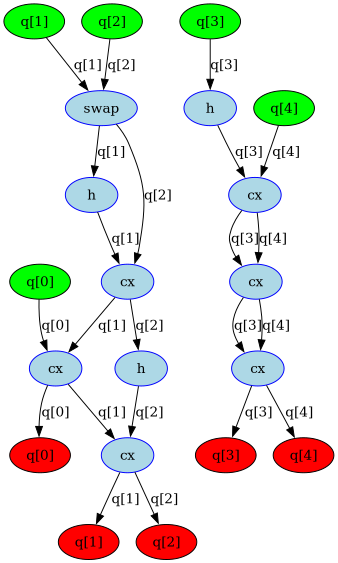

In [50]:
import qiskit.converters
import qiskit.visualization
 
random_circuit_dag = qiskit.converters.circuit_to_dag(random_circuit)
qiskit.visualization.dag_drawer(random_circuit_dag)

Let's check the dot generation actually

In [51]:
random_circuit_dag._to_dot()

'digraph {\n0 ;\n1 ;\n2 ;\n3 ;\n4 ;\n5 ;\n6 ;\n7 ;\n8 ;\n9 ;\n10 ;\n11 ;\n12 ;\n13 ;\n14 ;\n15 ;\n16 ;\n17 ;\n18 ;\n19 ;\n0 -> 16 ;\n2 -> 11 ;\n4 -> 11 ;\n6 -> 10 ;\n8 -> 14 ;\n11 -> 12 ;\n12 -> 13 ;\n11 -> 13 ;\n10 -> 14 ;\n13 -> 15 ;\n13 -> 16 ;\n16 -> 17 ;\n15 -> 17 ;\n14 -> 18 ;\n14 -> 18 ;\n18 -> 19 ;\n18 -> 19 ;\n16 -> 1 ;\n17 -> 5 ;\n17 -> 3 ;\n19 -> 7 ;\n19 -> 9 ;\n}\n'

Okay, pretty useless. Maybe, the edges will help?

In [52]:
list(random_circuit_dag.edges())

[(DAGInNode(wire=<Qubit register=(5, "q"), index=0>),
  DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(5, "q"), index=0>, <Qubit register=(5, "q"), index=1>), cargs=()),
  <Qubit register=(5, "q"), index=0>),
 (DAGInNode(wire=<Qubit register=(5, "q"), index=1>),
  DAGOpNode(op=Instruction(name='swap', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(5, "q"), index=1>, <Qubit register=(5, "q"), index=2>), cargs=()),
  <Qubit register=(5, "q"), index=1>),
 (DAGInNode(wire=<Qubit register=(5, "q"), index=2>),
  DAGOpNode(op=Instruction(name='swap', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(5, "q"), index=1>, <Qubit register=(5, "q"), index=2>), cargs=()),
  <Qubit register=(5, "q"), index=2>),
 (DAGInNode(wire=<Qubit register=(5, "q"), index=3>),
  DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(<Qubit register=(5, "q"), index=3>,), cargs=()),
  <Qubit register=(5, "

That's better, but sitll kinda problematic. Maybe let's revert to qasm3.

In [53]:
import qiskit.qasm3


print(qiskit.qasm3.dumps(random_circuit))

OPENQASM 3.0;
include "stdgates.inc";
qubit[5] q;
h q[3];
swap q[1], q[2];
h q[1];
cx q[1], q[2];
cx q[3], q[4];
h q[2];
cx q[0], q[1];
cx q[1], q[2];
cx q[3], q[4];
cx q[3], q[4];



Okay, MAYBE NOT. Let's continue fighting with the DAG. Chcecking out the dagdependency. It seems useless for us tbh


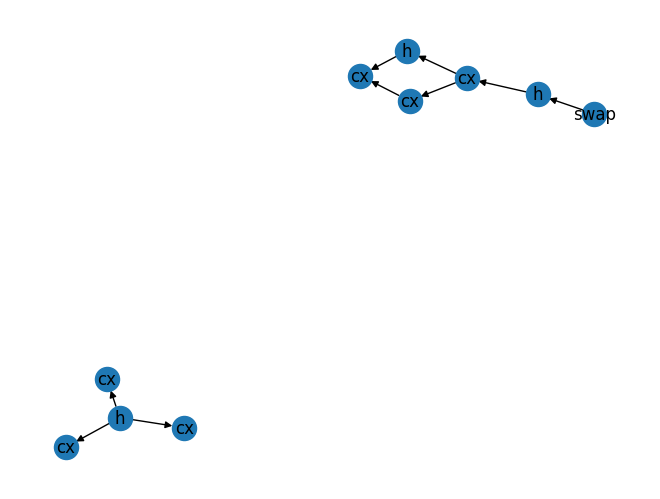

In [54]:
import rustworkx.visualization

random_dag_dependency = qiskit.converters.circuit_to_dagdependency(random_circuit)
random_dag_dependency_rx = random_dag_dependency.to_retworkx()
rustworkx.visualization.mpl_draw(random_dag_dependency_rx, with_labels=True, labels = lambda node: node.name)

random_dag_dependency_rx

Okay, probably the conversion of the original graph is more desired.

In [55]:
random_dag_nodes = list(random_circuit_dag.nodes())
random_dag_nodes

[DAGInNode(wire=<Qubit register=(5, "q"), index=0>),
 DAGOutNode(wire=<Qubit register=(5, "q"), index=0>),
 DAGInNode(wire=<Qubit register=(5, "q"), index=1>),
 DAGOutNode(wire=<Qubit register=(5, "q"), index=1>),
 DAGInNode(wire=<Qubit register=(5, "q"), index=2>),
 DAGOutNode(wire=<Qubit register=(5, "q"), index=2>),
 DAGInNode(wire=<Qubit register=(5, "q"), index=3>),
 DAGOutNode(wire=<Qubit register=(5, "q"), index=3>),
 DAGInNode(wire=<Qubit register=(5, "q"), index=4>),
 DAGOutNode(wire=<Qubit register=(5, "q"), index=4>),
 DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(<Qubit register=(5, "q"), index=3>,), cargs=()),
 DAGOpNode(op=Instruction(name='swap', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(5, "q"), index=1>, <Qubit register=(5, "q"), index=2>), cargs=()),
 DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(<Qubit register=(5, "q"), index=1>,), cargs=()),
 DAGOpNode(op=Instruction(name=

Some kind of conversion operation should happen here. Let me invent the internal format of that. Maybe initially, simple graph conversion is valid, because I probably won't need a tailoring for a special operations NOW.

Let's select only operations instrutions, and print them.

In [56]:
import qiskit.dagcircuit.dagnode

for node in random_dag_nodes:
    if isinstance(node, qiskit.dagcircuit.DAGOpNode):
        print(id(node))

139994746883936
139994746885952
139994746888112
139994746894016
139994746893872
139994746883504
139994746889840
139994746882352
139994746880912
139994746884944


Good, now let's see the edges again.

In [57]:
random_dag_edges = list(random_circuit_dag.edges())

for edge in random_dag_edges:
    print(edge)


(DAGInNode(wire=<Qubit register=(5, "q"), index=0>), DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(5, "q"), index=0>, <Qubit register=(5, "q"), index=1>), cargs=()), <Qubit register=(5, "q"), index=0>)
(DAGInNode(wire=<Qubit register=(5, "q"), index=1>), DAGOpNode(op=Instruction(name='swap', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(5, "q"), index=1>, <Qubit register=(5, "q"), index=2>), cargs=()), <Qubit register=(5, "q"), index=1>)
(DAGInNode(wire=<Qubit register=(5, "q"), index=2>), DAGOpNode(op=Instruction(name='swap', num_qubits=2, num_clbits=0, params=[]), qargs=(<Qubit register=(5, "q"), index=1>, <Qubit register=(5, "q"), index=2>), cargs=()), <Qubit register=(5, "q"), index=2>)
(DAGInNode(wire=<Qubit register=(5, "q"), index=3>), DAGOpNode(op=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qargs=(<Qubit register=(5, "q"), index=3>,), cargs=()), <Qubit register=(5, "q"), index=3>)
(DAGInNo

Now, let's setup conversion to nx. Let's check also that it is DAG.

In [58]:
import networkx as nx

circuit_dag_routing = nx.DiGraph()
circuit_dag_routing.add_nodes_from(random_dag_nodes)

circuit_dag_edges_nx = [(edge[0], edge[1], {"wire": edge[2]}) for edge in random_dag_edges] # edges in the qiskit formalism are literally in-edge, out-edge and a wire which is the connector
circuit_dag_routing.add_edges_from(circuit_dag_edges_nx)

nx.is_directed_acyclic_graph(circuit_dag_routing)

True

Let's also plot it.

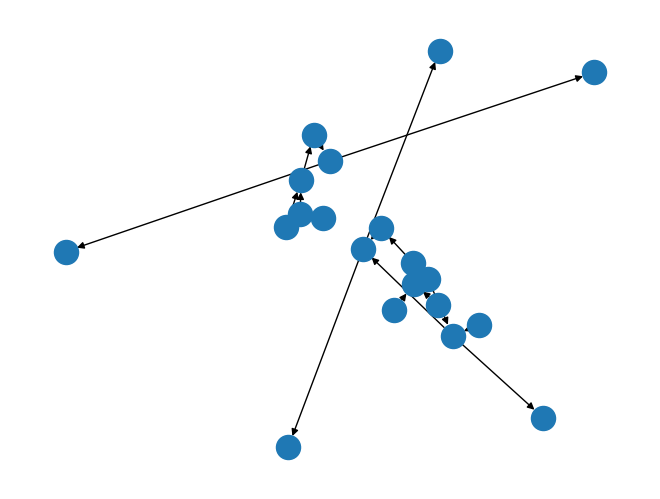

In [59]:
nx.draw(circuit_dag_routing)

Let's draw it a bit better

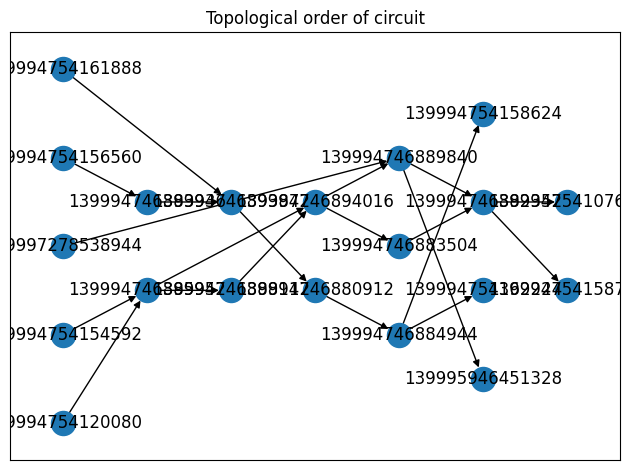

In [60]:
import matplotlib.pyplot as plt

for layer, nodes in enumerate(nx.topological_generations(circuit_dag_routing)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        circuit_dag_routing.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(circuit_dag_routing, subset_key="layer")

fig, ax = plt.subplots()
nx.draw_networkx(circuit_dag_routing, pos=pos, ax=ax)
ax.set_title("Topological order of circuit")
fig.tight_layout()
plt.show()

Let's then also add normal node labels.

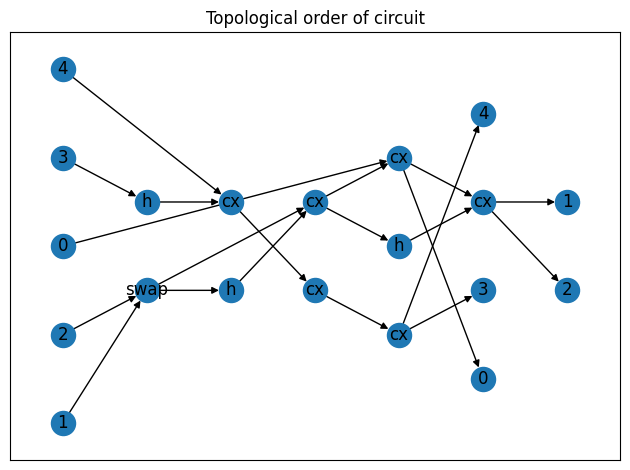

In [61]:
import qiskit.dagcircuit

circuit_labels_by_node = {}
for node in random_dag_nodes:
    if isinstance(node, qiskit.dagcircuit.DAGOpNode):
        circuit_labels_by_node[node] = node.op.name
    elif isinstance(node, (qiskit.dagcircuit.DAGInNode, qiskit.dagcircuit.DAGOutNode)):
        circuit_labels_by_node[node] = node.wire._index

fig, ax = plt.subplots()
nx.draw_networkx(circuit_dag_routing, pos=pos, ax=ax, labels=circuit_labels_by_node)
ax.set_title("Topological order of circuit")
fig.tight_layout()
plt.show()

I understood, that I would like to have an intermediate object layer conversion, to make it compatible with other backends. Let's create it with dataclasses.

In [62]:
import dataclasses

@dataclasses.dataclass(frozen=True)
class Qubit:
    is_start: bool
    index: int

@dataclasses.dataclass(frozen=True)
class Gate:
    qubits_participating: int
    name: str
    parent_id: int = dataclasses.field(repr=False)


Qubit(True, 3), Gate(2, "cx", 1) 

(Qubit(is_start=True, index=3), Gate(qubits_participating=2, name='cx'))

Now let's create a set of conversion routines.

In [63]:
random_dag_inner_nodes = []
for node in random_dag_nodes:
    if isinstance(node, qiskit.dagcircuit.DAGOpNode):
        gate_name = node.op.name
        gate_num_qubits = node.num_qubits
        gate_id = hash(node)
        routing_node = Gate(gate_num_qubits, gate_name, gate_id)
    elif isinstance(node, (qiskit.dagcircuit.DAGInNode, qiskit.dagcircuit.DAGOutNode)):
        qubit_index = node.wire._index
        if isinstance(node, qiskit.dagcircuit.DAGInNode):
            qubit_is_start = True
        elif isinstance(node, qiskit.dagcircuit.DAGOutNode):
            qubit_is_start = False
        routing_node = Qubit(qubit_is_start, qubit_index)
    else: 
        raise NotImplementedError("wrong node type!")
    random_dag_inner_nodes.append(routing_node)

        
    
random_dag_inner_nodes

[Qubit(is_start=True, index=0),
 Qubit(is_start=False, index=0),
 Qubit(is_start=True, index=1),
 Qubit(is_start=False, index=1),
 Qubit(is_start=True, index=2),
 Qubit(is_start=False, index=2),
 Qubit(is_start=True, index=3),
 Qubit(is_start=False, index=3),
 Qubit(is_start=True, index=4),
 Qubit(is_start=False, index=4),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=2, name='swap'),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=1, name='h'),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=2, name='cx'),
 Gate(qubits_participating=2, name='cx')]

Now let's convert the edges. Let's put the previous design into the function, and do the easy conversion here.

In [64]:
import quariadne.computational_graph

routing_edges = []

WIRE_ATTRIBUTE_NAME = "wire"


for edge in random_dag_edges:
    in_node, out_node, wire = edge
    in_routing_node = quariadne.computational_graph.ComputationalDAG._convert_qiskit_dag_node(in_node)
    out_routing_node = quariadne.computational_graph.ComputationalDAG._convert_qiskit_dag_node(out_node)
    routing_edge = (in_routing_node, out_routing_node,)
    routing_edges.append(routing_edge)

routing_edges

[(WireStart(qubit=LogicalQubit(index=0)),
  Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1)), name='cx')),
 (WireStart(qubit=LogicalQubit(index=1)),
  Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='swap')),
 (WireStart(qubit=LogicalQubit(index=2)),
  Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='swap')),
 (WireStart(qubit=LogicalQubit(index=3)),
  Gate(qubits_participating=(LogicalQubit(index=3),), name='h')),
 (WireStart(qubit=LogicalQubit(index=4)),
  Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)), name='cx')),
 (Gate(qubits_participating=(LogicalQubit(index=3),), name='h'),
  Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)), name='cx')),
 (Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='swap'),
  Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx')),
 (Gate(qubits_participating=(Lo

Here we see a problem, that we don't actually keep track of which logical wire the gate happens on, and probably this should be an important thing as well. Maybe we should deprecate the concept of the Logical qubit? Maybe. Or just creating a timestep based system? Let's try it, but I'd like to keep it simple

In [65]:
import quariadne.computational_graph
import typing


@dataclasses.dataclass
class Transition:
    from_node: quariadne.computational_graph.ComputationalNode
    to_node: quariadne.computational_graph.ComputationalNode
    qubit_index: int


Let's now see the result of our internal representation.

In [66]:
for edge in random_dag_edges:
    in_node, out_node, wire = edge
    wire_index = wire._index
    in_routing_node =  quariadne.computational_graph.ComputationalDAG._convert_qiskit_dag_node(in_node)
    out_routing_node = quariadne.computational_graph.ComputationalDAG._convert_qiskit_dag_node(out_node)
    transition = Transition(in_routing_node, out_routing_node, wire_index)
    print(transition)
    


Transition(from_node=WireStart(qubit=LogicalQubit(index=0)), to_node=Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1)), name='cx'), qubit_index=0)
Transition(from_node=WireStart(qubit=LogicalQubit(index=1)), to_node=Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='swap'), qubit_index=1)
Transition(from_node=WireStart(qubit=LogicalQubit(index=2)), to_node=Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='swap'), qubit_index=2)
Transition(from_node=WireStart(qubit=LogicalQubit(index=3)), to_node=Gate(qubits_participating=(LogicalQubit(index=3),), name='h'), qubit_index=3)
Transition(from_node=WireStart(qubit=LogicalQubit(index=4)), to_node=Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)), name='cx'), qubit_index=4)
Transition(from_node=Gate(qubits_participating=(LogicalQubit(index=3),), name='h'), to_node=Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)), nam

Hooray, we have our fully internal representation of the routing DAG!!

Now, let's design the full conversion function, for that let's create a final encapsulation for our routing circuit.

In [67]:

@dataclasses.dataclass
class RoutingCircuit:
    nodes: typing.List[quariadne.computational_graph.ComputationalNode]
    transitions: typing.List[quariadne.computational_graph.Transition]



And now, let's design a formation method for this dataclass.

In [68]:
circuit_nodes = []
circuit_transitions = []
for node in random_dag_nodes:
    circuit_node = quariadne.computational_graph.ComputationalDAG._convert_qiskit_dag_node(node)
    circuit_nodes.append(circuit_node)

for edge in random_dag_edges:
    circuit_transition = quariadne.computational_graph.ComputationalDAG._convert_qiskit_dag_edge(edge)
    circuit_transitions.append(circuit_transition)


random_routing_circuit = RoutingCircuit(circuit_nodes, circuit_transitions)
random_routing_circuit

RoutingCircuit(nodes=[WireStart(qubit=LogicalQubit(index=0)), WireEnd(qubit=LogicalQubit(index=0)), WireStart(qubit=LogicalQubit(index=1)), WireEnd(qubit=LogicalQubit(index=1)), WireStart(qubit=LogicalQubit(index=2)), WireEnd(qubit=LogicalQubit(index=2)), WireStart(qubit=LogicalQubit(index=3)), WireEnd(qubit=LogicalQubit(index=3)), WireStart(qubit=LogicalQubit(index=4)), WireEnd(qubit=LogicalQubit(index=4)), Gate(qubits_participating=(LogicalQubit(index=3),), name='h'), Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='swap'), Gate(qubits_participating=(LogicalQubit(index=1),), name='h'), Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=2),), name='h'), Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=1), Log

Packing everything up, now let's design a conversion of this circuit to nx graph.

In [69]:
random_routing_dag = nx.MultiDiGraph()
random_routing_dag.add_nodes_from(random_routing_circuit.nodes)
random_routing_dag.nodes

NodeView((WireStart(qubit=LogicalQubit(index=0)), WireEnd(qubit=LogicalQubit(index=0)), WireStart(qubit=LogicalQubit(index=1)), WireEnd(qubit=LogicalQubit(index=1)), WireStart(qubit=LogicalQubit(index=2)), WireEnd(qubit=LogicalQubit(index=2)), WireStart(qubit=LogicalQubit(index=3)), WireEnd(qubit=LogicalQubit(index=3)), WireStart(qubit=LogicalQubit(index=4)), WireEnd(qubit=LogicalQubit(index=4)), Gate(qubits_participating=(LogicalQubit(index=3),), name='h'), Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='swap'), Gate(qubits_participating=(LogicalQubit(index=1),), name='h'), Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=2),), name='h'), Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1)), name='cx'), Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(in

And now let's make the edges available

In [70]:
transition_as_edges = ((transition.from_node, transition.to_node) for transition in random_routing_circuit.transitions)
random_routing_dag.add_edges_from(transition_as_edges)
random_routing_dag.edges()

OutMultiEdgeDataView([(WireStart(qubit=LogicalQubit(index=0)), Gate(qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1)), name='cx')), (WireStart(qubit=LogicalQubit(index=1)), Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='swap')), (WireStart(qubit=LogicalQubit(index=2)), Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='swap')), (WireStart(qubit=LogicalQubit(index=3)), Gate(qubits_participating=(LogicalQubit(index=3),), name='h')), (WireStart(qubit=LogicalQubit(index=4)), Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)), name='cx')), (Gate(qubits_participating=(LogicalQubit(index=3),), name='h'), Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)), name='cx')), (Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='swap'), Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx')), (Gate(qubits_participating=(Lo

Let's design a function for displaying and plotting. I'll add special attributes for labels

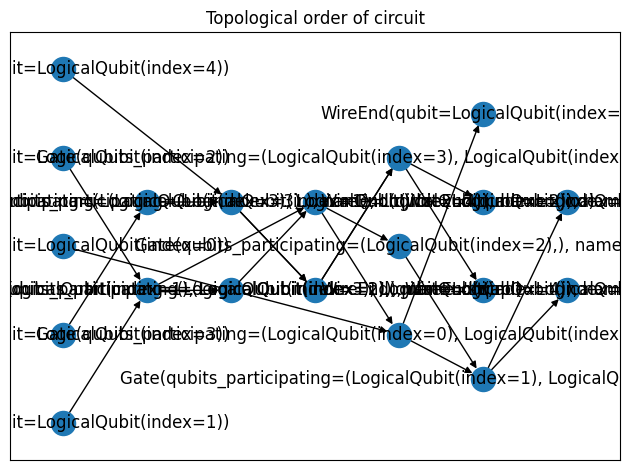

In [71]:
import matplotlib.pyplot as plt


circuit_labels_by_node = {}
for layer, nodes in enumerate(nx.topological_generations(random_routing_dag)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        random_routing_dag.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
pos = nx.multipartite_layout(random_routing_dag, subset_key="layer")

fig, ax = plt.subplots()
nx.draw_networkx(random_routing_dag, pos=pos, ax=ax)
ax.set_title("Topological order of circuit")
fig.tight_layout()
plt.show()

Not very shiny, let's add some edges and nodes labels. 

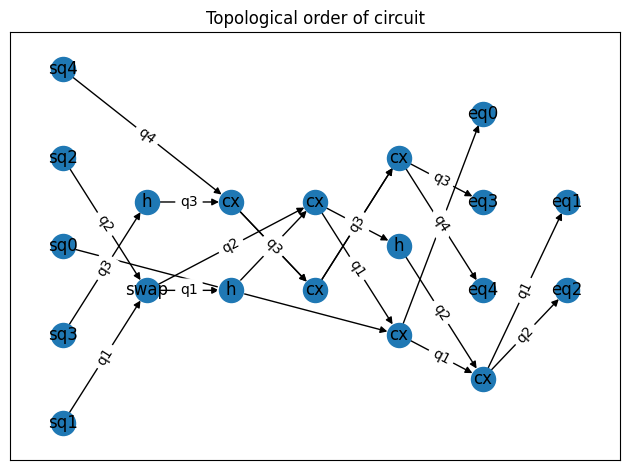

In [72]:
label_by_edge = {}
for transition in random_routing_circuit.transitions:
    edge = transition.as_nx_edge()
    edge_label = f"q{transition.underlying_qubit.index}"
    label_by_edge[edge] = edge_label

label_by_node = {}
for node in random_routing_circuit.nodes:
    label_by_node[node] = node.label


fig, ax = plt.subplots()
nx.draw_networkx(random_routing_dag, pos=pos, ax=ax, labels=label_by_node)
nx.draw_networkx_edge_labels(random_routing_dag,pos=pos, edge_labels=label_by_edge, ax=ax)
ax.set_title("Topological order of circuit")
fig.tight_layout()
plt.show()


The only broken thing now is the display of several edges from a gate to another gate, for now I won't treat this problem.

Let's get an exemplar hardware graph now. But first, let's test our inner routing circuit again.

(<Figure size 640x480 with 1 Axes>, <Axes: title={'center': 'Visualised DAG'}>)

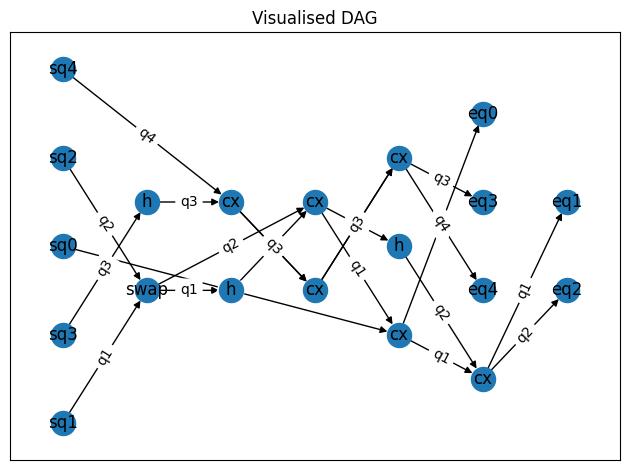

In [73]:
random_routing_circuit = quariadne.computational_graph.ComputationalDAG.from_qiskit_dag(random_circuit_dag)
random_routing_circuit.plot_dag()

Let's then get a generic backend.

In [74]:
import qiskit_ibm_runtime.fake_provider 

manila_backend = qiskit_ibm_runtime.fake_provider.FakeManilaV2()
coupling_graph = manila_backend.coupling_map.graph
coupling_graph

Let's convert it to networkx for now. First though let's visualise it.

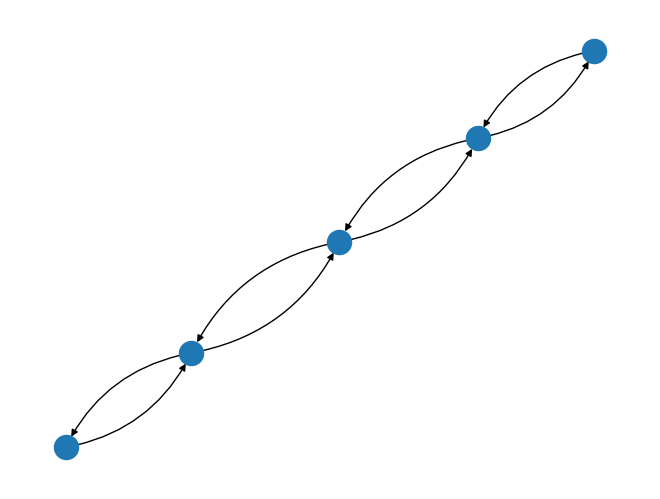

In [75]:
rustworkx.visualization.mpl_draw(coupling_graph)

Then let's get a node and edge list, and visualise the graph.

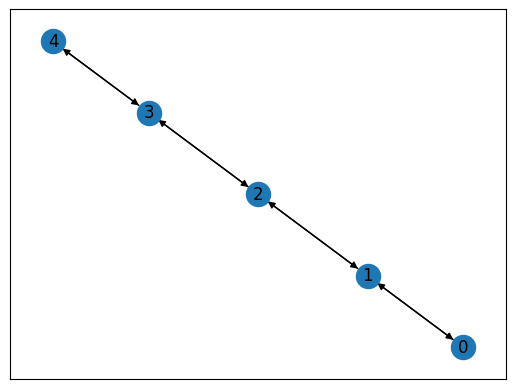

In [76]:
coupling_graph_nx = nx.DiGraph()
coupling_graph_nx.add_nodes_from(coupling_graph.node_indices())
coupling_graph_nx.add_edges_from(coupling_graph.edge_list())
nx.draw_networkx(coupling_graph_nx)

Now the fun part starts, we would like to express this problem as MILP. First, a variable definition. As we remember, the variables participating are:


$w^t_{A,U} = \"\pi^t(A)=u\"$  it is equal to one only if the logical cubit is in the  physical cubit $u$ 


$x^t_{A,u,v} = \" A \text{ goes } u\to v \text{ at time } t$


$y^t_{g,e} = \" \text{gate } g \text{ is executed at time }t \text{ on edge } e$, where edge $e$ is $(u,v)$ 




Let's define the tensor collection, where columns are $t$ time spaced, rows are physical qubits, and the third dimension is the logical qubit. Time spacing is obviously $n^2$ . We see that we need to introduce the circuit itself, making it decoupled from the DAG-like circuit.

In [77]:
type PhysicalByLogicalQubit = dict[circuit.LogicalQubit, circuit.PhysicalQubit]
type GateByLogicalQubit = dict[circuit.LogicalQubit, quariadne.computational_graph.Gate]

@dataclasses.dataclass(frozen=True)
class RoutedCircuit:
    participating_qubits: typing.Tuple[quariadne.circuit.LogicalQubit]
    computational_dag: quariadne.computational_graph.ComputationalDAG
    coupling_map: nx.MultiDiGraph
    qubit_mapping_by_timestep: dict[int, PhysicalByLogicalQubit]
    computational_operation_by_timestep: dict[int, GateByLogicalQubit]

Now let's enable the construction function for ILP specificall, using this class as basis. But first, let's convert to inner format the coupling map as well.

In [78]:
coupling_map_qubits = manila_backend.coupling_map.physical_qubits
physical_qubits = tuple(quariadne.circuit.PhysicalQubit(coupling_map_qubit) for coupling_map_qubit in coupling_map_qubits)
coupling_map_edgelist = manila_backend.coupling_map.graph.edge_list()
physical_qubits_connections = tuple((quariadne.circuit.PhysicalQubit(coupling_map_from), quariadne.circuit.PhysicalQubit(coupling_map_to)) for coupling_map_from, coupling_map_to in coupling_map_edgelist)
physical_qubits, physical_qubits_connections

((PhysicalQubit(index=0),
  PhysicalQubit(index=1),
  PhysicalQubit(index=2),
  PhysicalQubit(index=3),
  PhysicalQubit(index=4)),
 ((PhysicalQubit(index=0), PhysicalQubit(index=1)),
  (PhysicalQubit(index=1), PhysicalQubit(index=0)),
  (PhysicalQubit(index=1), PhysicalQubit(index=2)),
  (PhysicalQubit(index=2), PhysicalQubit(index=1)),
  (PhysicalQubit(index=2), PhysicalQubit(index=3)),
  (PhysicalQubit(index=3), PhysicalQubit(index=2)),
  (PhysicalQubit(index=3), PhysicalQubit(index=4)),
  (PhysicalQubit(index=4), PhysicalQubit(index=3))))

And designing a graph.

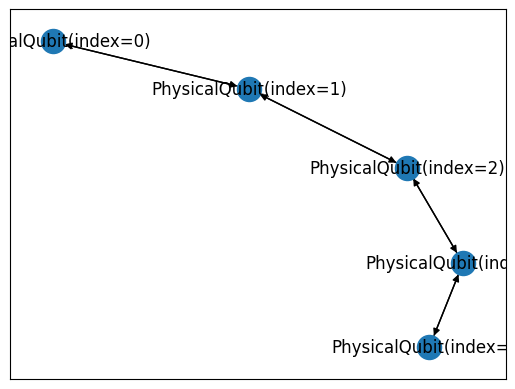

In [79]:
coupling_graph_nx = nx.DiGraph()
coupling_graph_nx.add_nodes_from(physical_qubits)
coupling_graph_nx.add_edges_from(physical_qubits_connections)
nx.draw_networkx(coupling_graph_nx)

Okay, let's continue making the routed circuit possible (for MILP tasks)

In [80]:
computational_operation_by_timestep = {}
initial_spacing = len(random_routing_circuit.nodes)**2
timestep = 0
for topological_generation in nx.topological_generations(random_routing_circuit.to_nx()):
    gate_by_logical_qubit = {}
    for node in topological_generation:
        if isinstance(node, quariadne.computational_graph.Gate):
            for qubit in node.qubits_participating:
                gate_by_logical_qubit[qubit] = node
    computational_operation_by_timestep[timestep] = gate_by_logical_qubit
    timestep+= initial_spacing

computational_operation_by_timestep

{0: {},
 400: {LogicalQubit(index=1): Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='swap'),
  LogicalQubit(index=2): Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='swap'),
  LogicalQubit(index=3): Gate(qubits_participating=(LogicalQubit(index=3),), name='h')},
 800: {LogicalQubit(index=1): Gate(qubits_participating=(LogicalQubit(index=1),), name='h'),
  LogicalQubit(index=3): Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)), name='cx'),
  LogicalQubit(index=4): Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)), name='cx')},
 1200: {LogicalQubit(index=1): Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'),
  LogicalQubit(index=2): Gate(qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)), name='cx'),
  LogicalQubit(index=3): Gate(qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)), name='cx'),
  LogicalQubit(in

Okay, now we have the material for logical interpretation of the circuit. Let's now design the integer program. First, let's get the random initial mapping. 

In [81]:
import random

computational_timesteps = computational_operation_by_timestep.keys()
starting_timestep = min(computational_timesteps)
ending_timestep = max(computational_timesteps)


But first, let's finally finalise our qubits containing paradigm. For that I'll define a new conceptual block, an abstract circuit, which is a group of operations apriori.

In [82]:
@dataclasses.dataclass(frozen=True)
class QuantumOperation:
    name: str
    qubits_participating: typing.Tuple[quariadne.circuit.LogicalQubit,...]

@dataclasses.dataclass()
class AbstractQuantumCircuit:
    operations: typing.List[QuantumOperation]
    qubits: typing.List[quariadne.circuit.LogicalQubit]

In [83]:
computational_qubits = [quariadne.circuit.LogicalQubit(qubit._index) for qubit in random_circuit.qubits]
operations = []
for instruction in random_circuit.data:
    instruction_operation, instruction_qubits = instruction.operation, instruction.qubits
    quantum_operation_name = instruction_operation.name
    quantum_operation_qubits = tuple(quariadne.circuit.LogicalQubit(qubit._index) for qubit in instruction.qubits)
    quantum_operation = QuantumOperation(quantum_operation_name, quantum_operation_qubits)
    operations.append(quantum_operation)

random_abstract_circuit = AbstractQuantumCircuit(operations, computational_qubits)
random_abstract_circuit

AbstractQuantumCircuit(operations=[QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=3),)), QuantumOperation(name='swap', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=1),)), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4))), QuantumOperation(name='h', qubits_participating=(LogicalQubit(index=2),)), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1))), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2))), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4))), QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)))], qubits=[LogicalQubit(index=0), LogicalQubit(index=1

Now let's define a generic Integeri programming interface for layout generation purposes. First a timstep-to-mapping interface! Let's generate an initial mapping:

In [84]:
import collections

random_abstract_circuit = quariadne.circuit.AbstractQuantumCircuit.from_qiskit_circuit(random_circuit)
qubit_count = len(random_abstract_circuit.qubits)
random_initial_mapping = {}
random_physical_qubits = physical_qubits
for logical_qubit, physical_qubit in zip(random_abstract_circuit.qubits, physical_qubits):
    random_initial_mapping[logical_qubit] = physical_qubit
current_mapping = random_initial_mapping
current_mapping

{LogicalQubit(index=0): PhysicalQubit(index=0),
 LogicalQubit(index=1): PhysicalQubit(index=1),
 LogicalQubit(index=2): PhysicalQubit(index=2),
 LogicalQubit(index=3): PhysicalQubit(index=3),
 LogicalQubit(index=4): PhysicalQubit(index=4)}

Then a construction of the mapping

In [85]:
import copy
qubit_mapping_by_timestep = {}
two_qubit_gate_operations = [operation for operation in random_abstract_circuit.operations if len(operation.qubits_participating) == 2]

for timestep, operation in enumerate(two_qubit_gate_operations):
    # if operation.name == "swap":
    #     swapped_qubit_first, swapped_qubit_second = operation.qubits_participating
    #     saved_second_qubit_mapping = current_mapping[swapped_qubit_second]
    #     current_mapping[swapped_qubit_second] = current_mapping[swapped_qubit_first]
    #     current_mapping[swapped_qubit_first] = saved_second_qubit_mapping
    qubit_mapping_by_timestep[timestep] = copy.deepcopy(current_mapping)



qubit_mapping_by_timestep

{0: {LogicalQubit(index=0): PhysicalQubit(index=0),
  LogicalQubit(index=1): PhysicalQubit(index=1),
  LogicalQubit(index=2): PhysicalQubit(index=2),
  LogicalQubit(index=3): PhysicalQubit(index=3),
  LogicalQubit(index=4): PhysicalQubit(index=4)},
 1: {LogicalQubit(index=0): PhysicalQubit(index=0),
  LogicalQubit(index=1): PhysicalQubit(index=1),
  LogicalQubit(index=2): PhysicalQubit(index=2),
  LogicalQubit(index=3): PhysicalQubit(index=3),
  LogicalQubit(index=4): PhysicalQubit(index=4)},
 2: {LogicalQubit(index=0): PhysicalQubit(index=0),
  LogicalQubit(index=1): PhysicalQubit(index=1),
  LogicalQubit(index=2): PhysicalQubit(index=2),
  LogicalQubit(index=3): PhysicalQubit(index=3),
  LogicalQubit(index=4): PhysicalQubit(index=4)},
 3: {LogicalQubit(index=0): PhysicalQubit(index=0),
  LogicalQubit(index=1): PhysicalQubit(index=1),
  LogicalQubit(index=2): PhysicalQubit(index=2),
  LogicalQubit(index=3): PhysicalQubit(index=3),
  LogicalQubit(index=4): PhysicalQubit(index=4)},
 4: 

Then we need to define a swap-controlling-interface

In [86]:
MOVEMENT_FROM_FIELD = "from"
MOVEMENT_TO_FIELD = "to"

qubit_movement_by_timestep = {}

for timestep, operation in enumerate(two_qubit_gate_operations):
    physical_qubit_movement_by_logical_qubit = {}
    current_mapping = qubit_mapping_by_timestep[timestep]    

    qubit_movement_by_timestep[timestep] = physical_qubit_movement_by_logical_qubit


qubit_movement_by_timestep

{0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}}

Superb, now let's design the execution monitor. 

In [87]:

physical_by_gate_by_timestep = {}
for timestep, operation in enumerate(two_qubit_gate_operations):
    physical_network_by_gate = {}
    current_mapping = qubit_mapping_by_timestep[timestep]
    if len(operation.qubits_participating) > 1:
        physical_qubits = tuple(current_mapping[logical_qubit] for logical_qubit in operation.qubits_participating)
        physical_network_by_gate[operation.qubits_participating] = physical_qubits
    physical_by_gate_by_timestep[timestep] = physical_network_by_gate

physical_by_gate_by_timestep

{0: {(LogicalQubit(index=1), LogicalQubit(index=2)): (PhysicalQubit(index=1),
   PhysicalQubit(index=2))},
 1: {(LogicalQubit(index=1), LogicalQubit(index=2)): (PhysicalQubit(index=1),
   PhysicalQubit(index=2))},
 2: {(LogicalQubit(index=3), LogicalQubit(index=4)): (PhysicalQubit(index=3),
   PhysicalQubit(index=4))},
 3: {(LogicalQubit(index=0), LogicalQubit(index=1)): (PhysicalQubit(index=0),
   PhysicalQubit(index=1))},
 4: {(LogicalQubit(index=1), LogicalQubit(index=2)): (PhysicalQubit(index=1),
   PhysicalQubit(index=2))},
 5: {(LogicalQubit(index=3), LogicalQubit(index=4)): (PhysicalQubit(index=3),
   PhysicalQubit(index=4))},
 6: {(LogicalQubit(index=3), LogicalQubit(index=4)): (PhysicalQubit(index=3),
   PhysicalQubit(index=4))}}

Now let's define the constraint controllers. After looking at all of this, I understood that probably I need to have a dedicated datastructures for keeping track of the ILP variables.  But let's try to do it with the constraint controllers. For that we need to define the variables mathematically. 

In [88]:
import numpy as np

worst_spacing =  qubit_count**2 
spaced_timesteps_count = len(two_qubit_gate_operations) * worst_spacing
qubit_movement_shape = (spaced_timesteps_count, qubit_count, len(random_physical_qubits), len(random_physical_qubits))

qubit_movement_variables = np.zeros(qubit_movement_shape)

for timestep in range(len(two_qubit_gate_operations)):
    spaced_timestep = timestep * worst_spacing
    current_mapping = qubit_mapping_by_timestep[timestep]
    # if :
    #     for logical_qubit, movement_description in current_movement.items():
    #         from_qubit = movement_description[MOVEMENT_FROM_FIELD]
    #         to_qubit = movement_description[MOVEMENT_TO_FIELD]
            
    #         del current_mapping[logical_qubit]
    #         print(qubit_movement_variables.shape)
    #         qubit_movement_variables[spaced_timestep, logical_qubit.index, from_qubit.index, to_qubit.index] = 1
    #         qubit_movement_variables[spaced_timestep, logical_qubit.index, to_qubit.index, from_qubit.index] = 1
            
    #     for logical_qubit, physical_qubit in current_mapping.items():
    #         mapping_variables[spaced_timestep_offseted, physical_qubit.index, logical_qubit.index] = 1
    
        
    for dummy_timestep in range(worst_spacing):
        spaced_timestep_offseted = spaced_timestep + dummy_timestep
        for logical_qubit, physical_qubit in current_mapping.items():
            if dummy_timestep == 0:
                if current_movement := qubit_movement_by_timestep[timestep]:
                    if logical_qubit in current_movement:
                        movement_description = current_movement[logical_qubit]
                        from_qubit = movement_description[MOVEMENT_FROM_FIELD]
                        to_qubit = movement_description[MOVEMENT_TO_FIELD]
                        qubit_movement_variables[spaced_timestep_offseted, logical_qubit.index, from_qubit.index, to_qubit.index] = 1
                        qubit_movement_variables[spaced_timestep_offseted, logical_qubit.index, to_qubit.index, from_qubit.index] = 1
                        continue
            qubit_movement_variables[spaced_timestep_offseted, logical_qubit.index, physical_qubit.index, physical_qubit.index] = 1
        

    

qubit_movement_variables

array([[[[1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1.]]],


       [[[1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 1., 0., 0.,

Then let's define the mapping variable:

In [89]:
mapping_variables_shape = (spaced_timesteps_count, qubit_count, qubit_count)

mapping_variables = np.zeros(mapping_variables_shape)

for timestep, operation in enumerate(two_qubit_gate_operations):
    spaced_timestep = timestep * worst_spacing
    current_mapping = qubit_mapping_by_timestep[timestep]
    for dummy_timestep in range(worst_spacing):
        spaced_timestep_offseted = spaced_timestep + dummy_timestep
        for logical_qubit, physical_qubit in current_mapping.items():
            mapping_variables[spaced_timestep_offseted, physical_qubit.index, logical_qubit.index] = 1

mapping_variables

array([[[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]],

       ...,

       [[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]],

       [[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]]], shape=(175, 5, 5))

Let's define the gate execution then. Well, formally: $y^t_{g,e} = \" \text{gate } g \text{ is executed at time }t \text{ on edge } e$

In [90]:
gate_execution_variables_shape = (spaced_timesteps_count, len(two_qubit_gate_operations), len(physical_qubits_connections))

gate_execution_variables = np.zeros(gate_execution_variables_shape)

for timestep, operation in enumerate(two_qubit_gate_operations):
    spaced_timestep = timestep * worst_spacing
    current_mapping = qubit_mapping_by_timestep[timestep]
    physical_qubit_connection = tuple(current_mapping[logical_qubit] for logical_qubit in operation.qubits_participating)
    print(physical_qubit_connection, operation)
    physical_qubit_connection_index = physical_qubits_connections.index(physical_qubit_connection)
    gate_execution_variables[spaced_timestep, timestep, physical_qubit_connection_index] = 1

gate_execution_variables

(PhysicalQubit(index=1), PhysicalQubit(index=2)) QuantumOperation(name='swap', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)))
(PhysicalQubit(index=1), PhysicalQubit(index=2)) QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)))
(PhysicalQubit(index=3), PhysicalQubit(index=4)) QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)))
(PhysicalQubit(index=0), PhysicalQubit(index=1)) QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=0), LogicalQubit(index=1)))
(PhysicalQubit(index=1), PhysicalQubit(index=2)) QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=1), LogicalQubit(index=2)))
(PhysicalQubit(index=3), PhysicalQubit(index=4)) QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), LogicalQubit(index=4)))
(PhysicalQubit(index=3), PhysicalQubit(index=4)) QuantumOperation(name='cx', qubits_participating=(LogicalQubit(index=3), 

array([[[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

Let's work on the constraints! First the qubit mapping uniqueness. $\sum_u w^t_{a,u} = 1, \quad \forall t, A$

In [91]:
full_size = np.concatenate([mapping_variables.flatten(),gate_execution_variables.flatten(),qubit_movement_variables.flatten()]).shape[0]
logical_uniqueness_matrix_shape = (spaced_timesteps_count*qubit_count, full_size)
logical_uniqueness_by_timestep = np.zeros(logical_uniqueness_matrix_shape)
mapping_padsize_after = full_size - mapping_variables.flatten().shape[0]  
padded_mapping_variables = np.pad(mapping_variables.flatten(), (0, mapping_padsize_after), constant_values=0)


constraint_num = 0
for timestep in range(spaced_timesteps_count):
    for logical_qubit in random_abstract_circuit.qubits:
        for physical_qubit in random_physical_qubits:
            flattened_index = (np.ravel_multi_index((timestep, physical_qubit.index, logical_qubit.index), mapping_variables_shape))
            logical_uniqueness_by_timestep[constraint_num,flattened_index]=1
        constraint_num+=1

logical_uniqueness_by_timestep.dot(padded_mapping_variables),

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 

Okay, so the uniqueness constraint matrix we constructed. Now, let's make the physical qubit mapping constraint $$\sum_A w^t_{A,u}, \quad  \forall t, u$$

In [92]:
physical_uniqueness_matrix_shape = (spaced_timesteps_count*qubit_count,full_size)
physical_uniqueness_by_timestep = np.zeros(physical_uniqueness_matrix_shape)
constraint_num = 0
for timestep in range(spaced_timesteps_count):
    for physical_qubit in random_physical_qubits:
        for logical_qubit in random_abstract_circuit.qubits:
            flattened_index = (np.ravel_multi_index((timestep, physical_qubit.index, logical_qubit.index), mapping_variables_shape))
            physical_uniqueness_by_timestep[constraint_num,flattened_index]=1
        constraint_num+=1

physical_uniqueness_by_timestep.dot(padded_mapping_variables)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

Great! Now, let's do some other constraints. The execution uniqueness: $\sum_{e \in E} y^t_{g_t, e}  = 1 , \quad \forall t : g_t \neq \emptyset$

In [93]:
gate_execution_uniqueness_matrix_shape = (len(two_qubit_gate_operations),full_size)
gate_execution_uniqueness = np.zeros(gate_execution_uniqueness_matrix_shape)
gate_execution_padsize_before = mapping_variables.flatten().shape[0]


gate_execution_padsize_after = full_size - gate_execution_padsize_before - gate_execution_variables.flatten().shape[0]
gate_execution_padded = np.pad(gate_execution_variables.flatten(), (gate_execution_padsize_before, gate_execution_padsize_after), constant_values=0)



for timestep, operation in enumerate(two_qubit_gate_operations):
    spaced_timestep = timestep * worst_spacing   
    for physical_edge_index in range(len(physical_qubits_connections)):
        flattened_index = gate_execution_padsize_before + (np.ravel_multi_index((spaced_timestep, timestep, physical_edge_index), gate_execution_variables_shape))
        gate_execution_uniqueness[timestep,flattened_index]=1

  
gate_execution_uniqueness.dot(gate_execution_padded)

array([1., 1., 1., 1., 1., 1., 1.])

Now let's create a set of mccormick inequalities for our next constraint, our beloved $$
y^t_{(A,B), (i,j)} = w^t_{A, i} \cdot w^t_{B,j}, \quad \forall t, g_t = (A,B) , (i,j) \in E
$$


the inequalities should look like this: 
$$
y^t_{(A,B), (i,j)} - w^t_{A, i} \le 0
$$
$$
y^t_{(A,B), (i,j)} - w^t_{B,j} \le 0 
$$
$$
0 \le y^t_{(A,B), (i,j)}  
$$
$$
 - 1 \le y^t_{(A,B), (i,j)}  - w^t_{A, i} - w^t_{B,j}
$$

In [94]:
gate_mapping_constraint_shape = (len(two_qubit_gate_operations)*len(physical_qubits_connections),full_size)
gate_mapping_constraint = np.zeros(gate_mapping_constraint_shape)
combined_gate_mapping_padded = padded_mapping_variables + gate_execution_padded


for timestep, operation in enumerate(two_qubit_gate_operations):
    spaced_timestep = worst_spacing * timestep
    for edge_index in range(len(physical_qubits_connections)):
        current_constraint = timestep * len(physical_qubits_connections) + edge_index
        gate_execution_index = gate_execution_padsize_before + (np.ravel_multi_index((spaced_timestep, timestep, edge_index), gate_execution_variables_shape))
        gate_mapping_constraint[current_constraint,gate_execution_index]=1

        left_logical_qubit, right_logical_qubit = operation.qubits_participating
        left_physical_qubit, right_physical_qubit =  physical_qubits_connections[edge_index]
        print(gate_execution_variables[spaced_timestep, timestep, edge_index], mapping_variables[spaced_timestep, left_physical_qubit.index, left_logical_qubit.index], mapping_variables[spaced_timestep,  right_physical_qubit.index, right_logical_qubit.index])

        

gate_mapping_constraint.dot(combined_gate_mapping_padded)

0.0 0.0 0.0
0.0 1.0 0.0
1.0 1.0 1.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 1.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 1.0 0.0
1.0 1.0 1.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 1.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 1.0 0.0
1.0 1.0 1.0
0.0 0.0 0.0
1.0 1.0 1.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 1.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 1.0 0.0
1.0 1.0 1.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 1.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 1.0 0.0
1.0 1.0 1.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 0.0 0.0
0.0 1.0 0.0
1.0 1.0 1.0
0.0 0.0 0.0


array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0.])

The next constraint is the left qubit part

In [95]:
gate_mapping_left_qubit_constraint = np.zeros(gate_mapping_constraint_shape)


for timestep, operation in enumerate(two_qubit_gate_operations):
    spaced_timestep = worst_spacing * timestep
    for edge_index in range(len(physical_qubits_connections)):
        current_constraint = timestep * len(physical_qubits_connections) + edge_index

        gate_execution_index = gate_execution_padsize_before + (np.ravel_multi_index((spaced_timestep, timestep, edge_index), gate_execution_variables_shape))
        gate_mapping_left_qubit_constraint[current_constraint,gate_execution_index]=1

        left_logical_qubit, right_logical_qubit = operation.qubits_participating
        left_physical_qubit, right_physical_qubit =  physical_qubits_connections[edge_index]


        left_qubit_mapping_index = (np.ravel_multi_index((spaced_timestep, left_physical_qubit.index, left_logical_qubit.index), mapping_variables_shape))
        gate_mapping_left_qubit_constraint[current_constraint,left_qubit_mapping_index]=-1


        print(left_logical_qubit, right_logical_qubit, left_physical_qubit,  right_physical_qubit, gate_execution_variables[spaced_timestep, timestep, edge_index], mapping_variables[spaced_timestep, left_physical_qubit.index, left_logical_qubit.index], mapping_variables[spaced_timestep,  right_physical_qubit.index, right_logical_qubit.index])
        

gate_mapping_left_qubit_constraint.dot(combined_gate_mapping_padded)

LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=0) PhysicalQubit(index=1) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=1) PhysicalQubit(index=0) 0.0 1.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=1) PhysicalQubit(index=2) 1.0 1.0 1.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=2) PhysicalQubit(index=1) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=2) PhysicalQubit(index=3) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=3) PhysicalQubit(index=2) 0.0 0.0 1.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=3) PhysicalQubit(index=4) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=4) PhysicalQubit(index=3) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=0) PhysicalQubit(index=1) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=1) PhysicalQubit(i

array([ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -1.,  0.,  0.])

Now let's do the right mapping.

In [96]:
gate_mapping_right_qubit_constraint = np.zeros(gate_mapping_constraint_shape)


for timestep, operation in enumerate(two_qubit_gate_operations):
    spaced_timestep = worst_spacing * timestep
    for edge_index in range(len(physical_qubits_connections)):

        current_constraint = timestep * len(physical_qubits_connections) + edge_index

        gate_execution_index = gate_execution_padsize_before + (np.ravel_multi_index((spaced_timestep, timestep, edge_index), gate_execution_variables_shape))
        gate_mapping_right_qubit_constraint[current_constraint,gate_execution_index]=1

        left_logical_qubit, right_logical_qubit = operation.qubits_participating
        left_physical_qubit, right_physical_qubit =  physical_qubits_connections[edge_index]


        right_qubit_mapping_index = (np.ravel_multi_index((spaced_timestep, right_physical_qubit.index, right_logical_qubit.index), mapping_variables_shape))
        gate_mapping_right_qubit_constraint[current_constraint,right_qubit_mapping_index]=-1


        print(left_logical_qubit, right_logical_qubit, left_physical_qubit,  right_physical_qubit, gate_execution_variables[spaced_timestep, timestep, edge_index], mapping_variables[spaced_timestep, left_physical_qubit.index, left_logical_qubit.index], mapping_variables[spaced_timestep,  right_physical_qubit.index, right_logical_qubit.index])

        

gate_mapping_right_qubit_constraint.dot(combined_gate_mapping_padded)

LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=0) PhysicalQubit(index=1) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=1) PhysicalQubit(index=0) 0.0 1.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=1) PhysicalQubit(index=2) 1.0 1.0 1.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=2) PhysicalQubit(index=1) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=2) PhysicalQubit(index=3) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=3) PhysicalQubit(index=2) 0.0 0.0 1.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=3) PhysicalQubit(index=4) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=4) PhysicalQubit(index=3) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=0) PhysicalQubit(index=1) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=1) PhysicalQubit(i

array([ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

And finally let's check our full qubit constraint!

In [97]:
gate_mapping_full_qubit_constraint = np.zeros(gate_mapping_constraint_shape)


for timestep, operation in enumerate(two_qubit_gate_operations):
    spaced_timestep = worst_spacing * timestep
    for edge_index in range(len(physical_qubits_connections)):

        current_constraint = timestep * len(physical_qubits_connections) + edge_index

        gate_execution_index = gate_execution_padsize_before + (np.ravel_multi_index((spaced_timestep, timestep, edge_index), gate_execution_variables_shape))
        gate_mapping_full_qubit_constraint[current_constraint,gate_execution_index]=1

        left_logical_qubit, right_logical_qubit = operation.qubits_participating
        left_physical_qubit, right_physical_qubit =  physical_qubits_connections[edge_index]


        right_qubit_mapping_index = (np.ravel_multi_index((spaced_timestep, right_physical_qubit.index, right_logical_qubit.index), mapping_variables_shape))
        gate_mapping_full_qubit_constraint[current_constraint,right_qubit_mapping_index]=-1
        left_qubit_mapping_index = (np.ravel_multi_index((spaced_timestep, left_physical_qubit.index, left_logical_qubit.index), mapping_variables_shape))
        gate_mapping_full_qubit_constraint[current_constraint,left_qubit_mapping_index]=-1



        print(left_logical_qubit, right_logical_qubit, left_physical_qubit,  right_physical_qubit, gate_execution_variables[spaced_timestep, timestep, edge_index], mapping_variables[spaced_timestep, left_physical_qubit.index, left_logical_qubit.index], mapping_variables[spaced_timestep,  right_physical_qubit.index, right_logical_qubit.index])

        

gate_mapping_full_qubit_constraint.dot(combined_gate_mapping_padded)

LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=0) PhysicalQubit(index=1) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=1) PhysicalQubit(index=0) 0.0 1.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=1) PhysicalQubit(index=2) 1.0 1.0 1.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=2) PhysicalQubit(index=1) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=2) PhysicalQubit(index=3) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=3) PhysicalQubit(index=2) 0.0 0.0 1.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=3) PhysicalQubit(index=4) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=4) PhysicalQubit(index=3) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=0) PhysicalQubit(index=1) 0.0 0.0 0.0
LogicalQubit(index=1) LogicalQubit(index=2) PhysicalQubit(index=1) PhysicalQubit(i

array([ 0., -1., -1.,  0.,  0., -1.,  0.,  0.,  0., -1., -1.,  0.,  0.,
       -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0., -1.,  0.,
        0., -1.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0., -1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,
        0., -1., -1.,  0.])

That's great! Now, let's define some other constraints and conditions. For example, let's start with the flow condition out:
$$
w^t_{A,U} = x^t_{A, U, U} + \sum_{\mathcal{N}(u)} x^t_{A,U, V}, \forall t \lt m
$$

In [98]:
flow_condition_out_shape = (spaced_timesteps_count * qubit_count*len(random_physical_qubits),full_size)
flow_condition_out_constraint = np.zeros(flow_condition_out_shape)

qubit_movement_padsize_before = mapping_variables.flatten().shape[0] + gate_execution_variables.flatten().shape[0]


qubit_movement_padded = np.pad(qubit_movement_variables.flatten(), (qubit_movement_padsize_before, 0), constant_values=0)

full_routing_variables = padded_mapping_variables + gate_execution_padded + qubit_movement_padded

current_constraint_idx = 0
for spaced_timestep in range(spaced_timesteps_count):
    for logical_qubit in computational_qubits:
        for physical_qubit in random_physical_qubits:

    
    
            
    
            qubit_mapping_index = (np.ravel_multi_index((spaced_timestep, physical_qubit.index, logical_qubit.index), mapping_variables_shape))
            flow_condition_out_constraint[current_constraint_idx,qubit_mapping_index]=1

            qubit_movement_self_index = qubit_movement_padsize_before + (np.ravel_multi_index((spaced_timestep, logical_qubit.index, physical_qubit.index, physical_qubit.index), qubit_movement_shape))
            flow_condition_out_constraint[current_constraint_idx, qubit_movement_self_index]=-1
            
            neighbouring_physical_qubits = coupling_graph_nx.neighbors(physical_qubit)
            for neighbouring_qubit in neighbouring_physical_qubits:
                qubit_movement_to_neigbour_index = qubit_movement_padsize_before+ (np.ravel_multi_index((spaced_timestep, logical_qubit.index, physical_qubit.index, neighbouring_qubit.index), qubit_movement_shape))
                flow_condition_out_constraint[current_constraint_idx, qubit_movement_to_neigbour_index]=-1

                    
    
            current_constraint_idx+=1


flow_condition_out_constraint.dot(full_routing_variables)

array([0., 0., 0., ..., 0., 0., 0.], shape=(4375,))

And now the flow condition (in) : $$
w^t_{A,U} = x^{t-1}_{A, U, U} + \sum_{\mathcal{N}(u)} x^{t-1}_{A,U, V}, \forall t \gt 0
$$

In [99]:
flow_condition_in_shape = ((spaced_timesteps_count-1) * qubit_count*len(random_physical_qubits),full_size)
flow_condition_in_constraint = np.zeros(flow_condition_in_shape)

current_constraint_idx = 0
for spaced_timestep in range(1,spaced_timesteps_count):
    previous_timestep = spaced_timestep-1
    for logical_qubit in computational_qubits:
        for physical_qubit in random_physical_qubits:
            
            qubit_mapping_index = (np.ravel_multi_index((spaced_timestep, physical_qubit.index, logical_qubit.index), mapping_variables_shape))
            flow_condition_in_constraint[current_constraint_idx,qubit_mapping_index]=1

            qubit_movement_prev_self_index = qubit_movement_padsize_before + (np.ravel_multi_index((previous_timestep, logical_qubit.index, physical_qubit.index, physical_qubit.index), qubit_movement_shape))
            flow_condition_in_constraint[current_constraint_idx, qubit_movement_prev_self_index]=-1
            
            neighbouring_physical_qubits = coupling_graph_nx.neighbors(physical_qubit)
            for neighbouring_qubit in neighbouring_physical_qubits:
                qubit_movement_from_neigbour_index = qubit_movement_padsize_before+ (np.ravel_multi_index((previous_timestep, logical_qubit.index, physical_qubit.index, neighbouring_qubit.index), qubit_movement_shape))
                flow_condition_in_constraint[current_constraint_idx, qubit_movement_from_neigbour_index]=-1

                    
    
            current_constraint_idx+=1


flow_condition_in_constraint.dot(full_routing_variables)

array([0., 0., 0., ..., 0., 0., 0.], shape=(4350,))

Finally, let's get an objective function.

In [100]:
OPTIMISATION_COEFFICIENT = 0.5
optimisation_coefficients = np.zeros(full_routing_variables.shape)

for spaced_timestep in range(spaced_timesteps_count):
    for logical_qubit in computational_qubits:
        for from_physical_qubit in random_physical_qubits:
            for to_physical_qubit in random_physical_qubits:
                if to_physical_qubit != from_physical_qubit:
                    qubit_movement_index = qubit_movement_padsize_before + (np.ravel_multi_index((spaced_timestep, logical_qubit.index, from_physical_qubit.index, to_physical_qubit.index), qubit_movement_shape))
                    optimisation_coefficients[qubit_movement_index] = OPTIMISATION_COEFFICIENT


optimisation_coefficients

array([0. , 0. , 0. , ..., 0.5, 0.5, 0. ], shape=(36050,))

Let's now get us a list of constraints.  But first let's define the bounds. 

In [101]:
import scipy.optimize

DEFAULT_INTEGRALITY = np.ones(full_routing_variables.shape)
ALL_VARIABLES_LOWER_BOUND = np.zeros(full_routing_variables.shape)
ALL_VARIABLES_UPPER_BOUND = np.ones(full_routing_variables.shape)
ALL_VARIABLES_BOUNDS = scipy.optimize.Bounds(ALL_VARIABLES_LOWER_BOUND, ALL_VARIABLES_UPPER_BOUND)
ALL_VARIABLES_BOUNDS, DEFAULT_INTEGRALITY

(Bounds(array([0., 0., 0., ..., 0., 0., 0.], shape=(36050,)), array([1., 1., 1., ..., 1., 1., 1.], shape=(36050,))),
 array([1., 1., 1., ..., 1., 1., 1.], shape=(36050,)))

Now let's do the constraints. First the logical uniqueness.

In [102]:
LOGICAL_UNIQUENESS_LOWER_BOUND = 1
LOGICAL_UNIQUENESS_UPPER_BOUND = 1
logical_uniqueness_constraint = scipy.optimize.LinearConstraint(logical_uniqueness_by_timestep, LOGICAL_UNIQUENESS_LOWER_BOUND, LOGICAL_UNIQUENESS_UPPER_BOUND)
logical_uniqueness_constraint

Then physical uniqueness.

In [103]:
PHYSICAL_UNIQUENESS_LOWER_BOUND = 1
PHYSICAL_UNIQUENESS_UPPER_BOUND = 1
physical_uniqueness_constraint = scipy.optimize.LinearConstraint(physical_uniqueness_by_timestep, PHYSICAL_UNIQUENESS_LOWER_BOUND, PHYSICAL_UNIQUENESS_UPPER_BOUND)
physical_uniqueness_constraint

Now -- the gate execution uniqueness

In [104]:
EXECUTION_UNIQUENESS_LOWER_BOUND = 1
EXECUTION_UNIQUENESS_UPPER_BOUND = 1
gate_execution_uniqueness_constraint = scipy.optimize.LinearConstraint(gate_execution_uniqueness, EXECUTION_UNIQUENESS_LOWER_BOUND, EXECUTION_UNIQUENESS_UPPER_BOUND)
gate_execution_uniqueness_constraint

Now it starts with the MCCORMICK mapping

In [105]:
MCCORMICK_GATE_MAPPING_LOWER_BOUND = 0
MCCORMICK_GATE_MAPPING_UPPER_BOUND = np.inf
mccormick_gate_mapping_constraint = scipy.optimize.LinearConstraint(gate_mapping_constraint, MCCORMICK_GATE_MAPPING_LOWER_BOUND, MCCORMICK_GATE_MAPPING_UPPER_BOUND)
mccormick_gate_mapping_constraint

now left and right of mccormick

In [106]:
MCCORMICK_SIDE_LOWER_BOUND = - np.inf
MCCORMICK_SIDE_UPPER_BOUND = 0
mccormick_left_mapping_constraint = scipy.optimize.LinearConstraint(gate_mapping_left_qubit_constraint, MCCORMICK_SIDE_LOWER_BOUND, MCCORMICK_SIDE_UPPER_BOUND)
mccormick_right_mapping_constraint = scipy.optimize.LinearConstraint(gate_mapping_right_qubit_constraint, MCCORMICK_SIDE_LOWER_BOUND, MCCORMICK_SIDE_UPPER_BOUND)
mccormick_left_mapping_constraint, mccormick_right_mapping_constraint

(<scipy.optimize._constraints.LinearConstraint at 0x7f531c321cd0>,
 <scipy.optimize._constraints.LinearConstraint at 0x7f5310fadeb0>)

Finally full mccormick

In [107]:
MCCORMICK_FULL_LOWER_BOUND = -1 
MCCORMICK_FULL_UPPER_BOUND = np.inf
mccormick_full_mapping_constraint = scipy.optimize.LinearConstraint(gate_mapping_full_qubit_constraint, MCCORMICK_FULL_LOWER_BOUND, MCCORMICK_FULL_UPPER_BOUND)
mccormick_full_mapping_constraint

And the flow conditions

In [108]:
FLOW_LOWER_BOUND = 0
FLOW_UPPER_BOUND = 0
flow_in_constraint = scipy.optimize.LinearConstraint(flow_condition_in_constraint, FLOW_LOWER_BOUND, FLOW_UPPER_BOUND)
flow_out_constraint = scipy.optimize.LinearConstraint(flow_condition_out_constraint, FLOW_LOWER_BOUND, FLOW_UPPER_BOUND)
flow_in_constraint, flow_out_constraint

(<scipy.optimize._constraints.LinearConstraint at 0x7f5310fb5d00>,
 <scipy.optimize._constraints.LinearConstraint at 0x7f531c325e50>)

Let's unite all the constraints

In [109]:
QUBIT_ROUTING_CONSTRAINTS = [logical_uniqueness_constraint, physical_uniqueness_constraint, gate_execution_uniqueness_constraint, mccormick_gate_mapping_constraint, mccormick_left_mapping_constraint, mccormick_right_mapping_constraint, mccormick_full_mapping_constraint, flow_in_constraint, flow_out_constraint]
QUBIT_ROUTING_CONSTRAINTS

And finally, let's run the milp instance!

In [110]:
milp_result = scipy.optimize.milp(optimisation_coefficients, integrality=DEFAULT_INTEGRALITY, bounds=ALL_VARIABLES_BOUNDS, constraints=QUBIT_ROUTING_CONSTRAINTS)
milp_result

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 0.0
              x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 mip_node_count: 1
 mip_dual_bound: 0.0
        mip_gap: 0.0

Let's now write a function recovery from the results.

In [111]:
reconstructed_mapping = np.zeros(mapping_variables_shape)

for ravel_idx in range(len(mapping_variables.flatten())):
    mapping_position = np.unravel_index(ravel_idx, mapping_variables_shape)
    reconstructed_mapping[mapping_position] = milp_result.x[ravel_idx]


reconstructed_mapping

array([[[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]], shape=(175, 5, 5))

Then the gate execution variable

In [112]:
reconstructed_gate_execution = np.zeros(gate_execution_variables_shape)

for ravel_idx in range(gate_execution_padsize_before, gate_execution_padsize_before+len(gate_execution_variables.flatten())):
    gate_execution_position = np.unravel_index(ravel_idx-gate_execution_padsize_before, gate_execution_variables_shape)
    reconstructed_gate_execution[gate_execution_position] = milp_result.x[ravel_idx]


reconstructed_gate_execution

array([[[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

And finally, the swap variables!

In [113]:
reconstructed_movement_variables = np.zeros(qubit_movement_shape)

for ravel_idx in range(qubit_movement_padsize_before, qubit_movement_padsize_before+len(reconstructed_movement_variables.flatten())):
    qubit_movement_position = np.unravel_index(ravel_idx-qubit_movement_padsize_before, qubit_movement_shape)
    reconstructed_movement_variables[qubit_movement_position] = milp_result.x[ravel_idx]


reconstructed_movement_variables

array([[[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0.,

Finally, to deduce the needed swaps, we need to find the swaps inside the qubit movement. But for now, let's just check that they all just equal to what have been previously.

In [114]:
(qubit_movement_variables != reconstructed_movement_variables).sum()

np.int64(1400)

They're not! That means that either our construction is wrong, or something went wrong in the end. Let's reconstruct the circuit then! Let's start with the gate execution, as the simplest variable possible.

In [116]:
np.argwhere(reconstructed_gate_execution), np.argwhere(gate_execution_variables)

(array([[  0,   0,   5],
        [ 25,   1,   5],
        [ 50,   2,   0],
        [ 75,   3,   7],
        [100,   4,   5],
        [125,   5,   0],
        [150,   6,   0]]),
 array([[  0,   0,   2],
        [ 25,   1,   2],
        [ 50,   2,   6],
        [ 75,   3,   0],
        [100,   4,   2],
        [125,   5,   6],
        [150,   6,   6]]))

It seems fine, however the system changed the pattern a bit. Let's check the qubit_movement.

In [119]:
for movements in np.argwhere(reconstructed_movement_variables):
    print(movements)

[0 0 4 4]
[0 1 3 3]
[0 2 2 2]
[0 3 0 0]
[0 4 1 1]
[1 0 4 4]
[1 1 3 3]
[1 2 2 2]
[1 3 0 0]
[1 4 1 1]
[2 0 4 4]
[2 1 3 3]
[2 2 2 2]
[2 3 0 0]
[2 4 1 1]
[3 0 4 4]
[3 1 3 3]
[3 2 2 2]
[3 3 0 0]
[3 4 1 1]
[4 0 4 4]
[4 1 3 3]
[4 2 2 2]
[4 3 0 0]
[4 4 1 1]
[5 0 4 4]
[5 1 3 3]
[5 2 2 2]
[5 3 0 0]
[5 4 1 1]
[6 0 4 4]
[6 1 3 3]
[6 2 2 2]
[6 3 0 0]
[6 4 1 1]
[7 0 4 4]
[7 1 3 3]
[7 2 2 2]
[7 3 0 0]
[7 4 1 1]
[8 0 4 4]
[8 1 3 3]
[8 2 2 2]
[8 3 0 0]
[8 4 1 1]
[9 0 4 4]
[9 1 3 3]
[9 2 2 2]
[9 3 0 0]
[9 4 1 1]
[10  0  4  4]
[10  1  3  3]
[10  2  2  2]
[10  3  0  0]
[10  4  1  1]
[11  0  4  4]
[11  1  3  3]
[11  2  2  2]
[11  3  0  0]
[11  4  1  1]
[12  0  4  4]
[12  1  3  3]
[12  2  2  2]
[12  3  0  0]
[12  4  1  1]
[13  0  4  4]
[13  1  3  3]
[13  2  2  2]
[13  3  0  0]
[13  4  1  1]
[14  0  4  4]
[14  1  3  3]
[14  2  2  2]
[14  3  0  0]
[14  4  1  1]
[15  0  4  4]
[15  1  3  3]
[15  2  2  2]
[15  3  0  0]
[15  4  1  1]
[16  0  4  4]
[16  1  3  3]
[16  2  2  2]
[16  3  0  0]
[16  4  1  1]
[17  0  4 

Okay, finally let's verify it with the mapping, and move on.

In [120]:
for mappings in np.argwhere(reconstructed_mapping):
    print(mappings)

[0 0 3]
[0 1 4]
[0 2 2]
[0 3 1]
[0 4 0]
[1 0 3]
[1 1 4]
[1 2 2]
[1 3 1]
[1 4 0]
[2 0 3]
[2 1 4]
[2 2 2]
[2 3 1]
[2 4 0]
[3 0 3]
[3 1 4]
[3 2 2]
[3 3 1]
[3 4 0]
[4 0 3]
[4 1 4]
[4 2 2]
[4 3 1]
[4 4 0]
[5 0 3]
[5 1 4]
[5 2 2]
[5 3 1]
[5 4 0]
[6 0 3]
[6 1 4]
[6 2 2]
[6 3 1]
[6 4 0]
[7 0 3]
[7 1 4]
[7 2 2]
[7 3 1]
[7 4 0]
[8 0 3]
[8 1 4]
[8 2 2]
[8 3 1]
[8 4 0]
[9 0 3]
[9 1 4]
[9 2 2]
[9 3 1]
[9 4 0]
[10  0  3]
[10  1  4]
[10  2  2]
[10  3  1]
[10  4  0]
[11  0  3]
[11  1  4]
[11  2  2]
[11  3  1]
[11  4  0]
[12  0  3]
[12  1  4]
[12  2  2]
[12  3  1]
[12  4  0]
[13  0  3]
[13  1  4]
[13  2  2]
[13  3  1]
[13  4  0]
[14  0  3]
[14  1  4]
[14  2  2]
[14  3  1]
[14  4  0]
[15  0  3]
[15  1  4]
[15  2  2]
[15  3  1]
[15  4  0]
[16  0  3]
[16  1  4]
[16  2  2]
[16  3  1]
[16  4  0]
[17  0  3]
[17  1  4]
[17  2  2]
[17  3  1]
[17  4  0]
[18  0  3]
[18  1  4]
[18  2  2]
[18  3  1]
[18  4  0]
[19  0  3]
[19  1  4]
[19  2  2]
[19  3  1]
[19  4  0]
[20  0  3]
[20  1  4]
[20  2  2]
[20  3  1]
[20  4

Seems coherent. Well, let's encapsulate it into a router!